In [16]:
# Neccesary libraries 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from sklearn.inspection import PartialDependenceDisplay
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import networkx as nx
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.linear_model import LinearRegression

In [1]:

file_path = 'youe directory'
marketing_data = pd.read_csv(file_path)


marketing_data.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,0,0,1,0,0,1529,1441,0
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,0,0,0,1,0,0,21,15,0
2,71613.0,0,0,26,426,49,127,111,21,42,...,1,0,0,0,1,0,0,734,692,0
3,26646.0,1,0,26,11,4,20,10,3,5,...,1,0,0,0,1,0,0,48,43,0
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,0,0,0,0,0,1,407,392,0


# Data Cleaning

In [4]:
# 1.Remove leading space from the income’s column name
marketing_data.rename(columns=lambda x: x.strip(), inplace=True)

# 2. Remove dollar signs from the values of Income column
marketing_data['Income'] = marketing_data['Income'].replace('[\$,]', '', regex=True)

# 3. Handle missing values in the Income column (e.g., by filling with the median)
marketing_data['Income'] = pd.to_numeric(marketing_data['Income'], errors='coerce')
marketing_data['Income'].fillna(marketing_data['Income'].median(), inplace=True)

# Check the cleaned data
marketing_data.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,0,0,1,0,0,1529,1441,0
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,0,0,0,1,0,0,21,15,0
2,71613.0,0,0,26,426,49,127,111,21,42,...,1,0,0,0,1,0,0,734,692,0
3,26646.0,1,0,26,11,4,20,10,3,5,...,1,0,0,0,1,0,0,48,43,0
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,0,0,0,0,0,1,407,392,0


# Outlier cheking

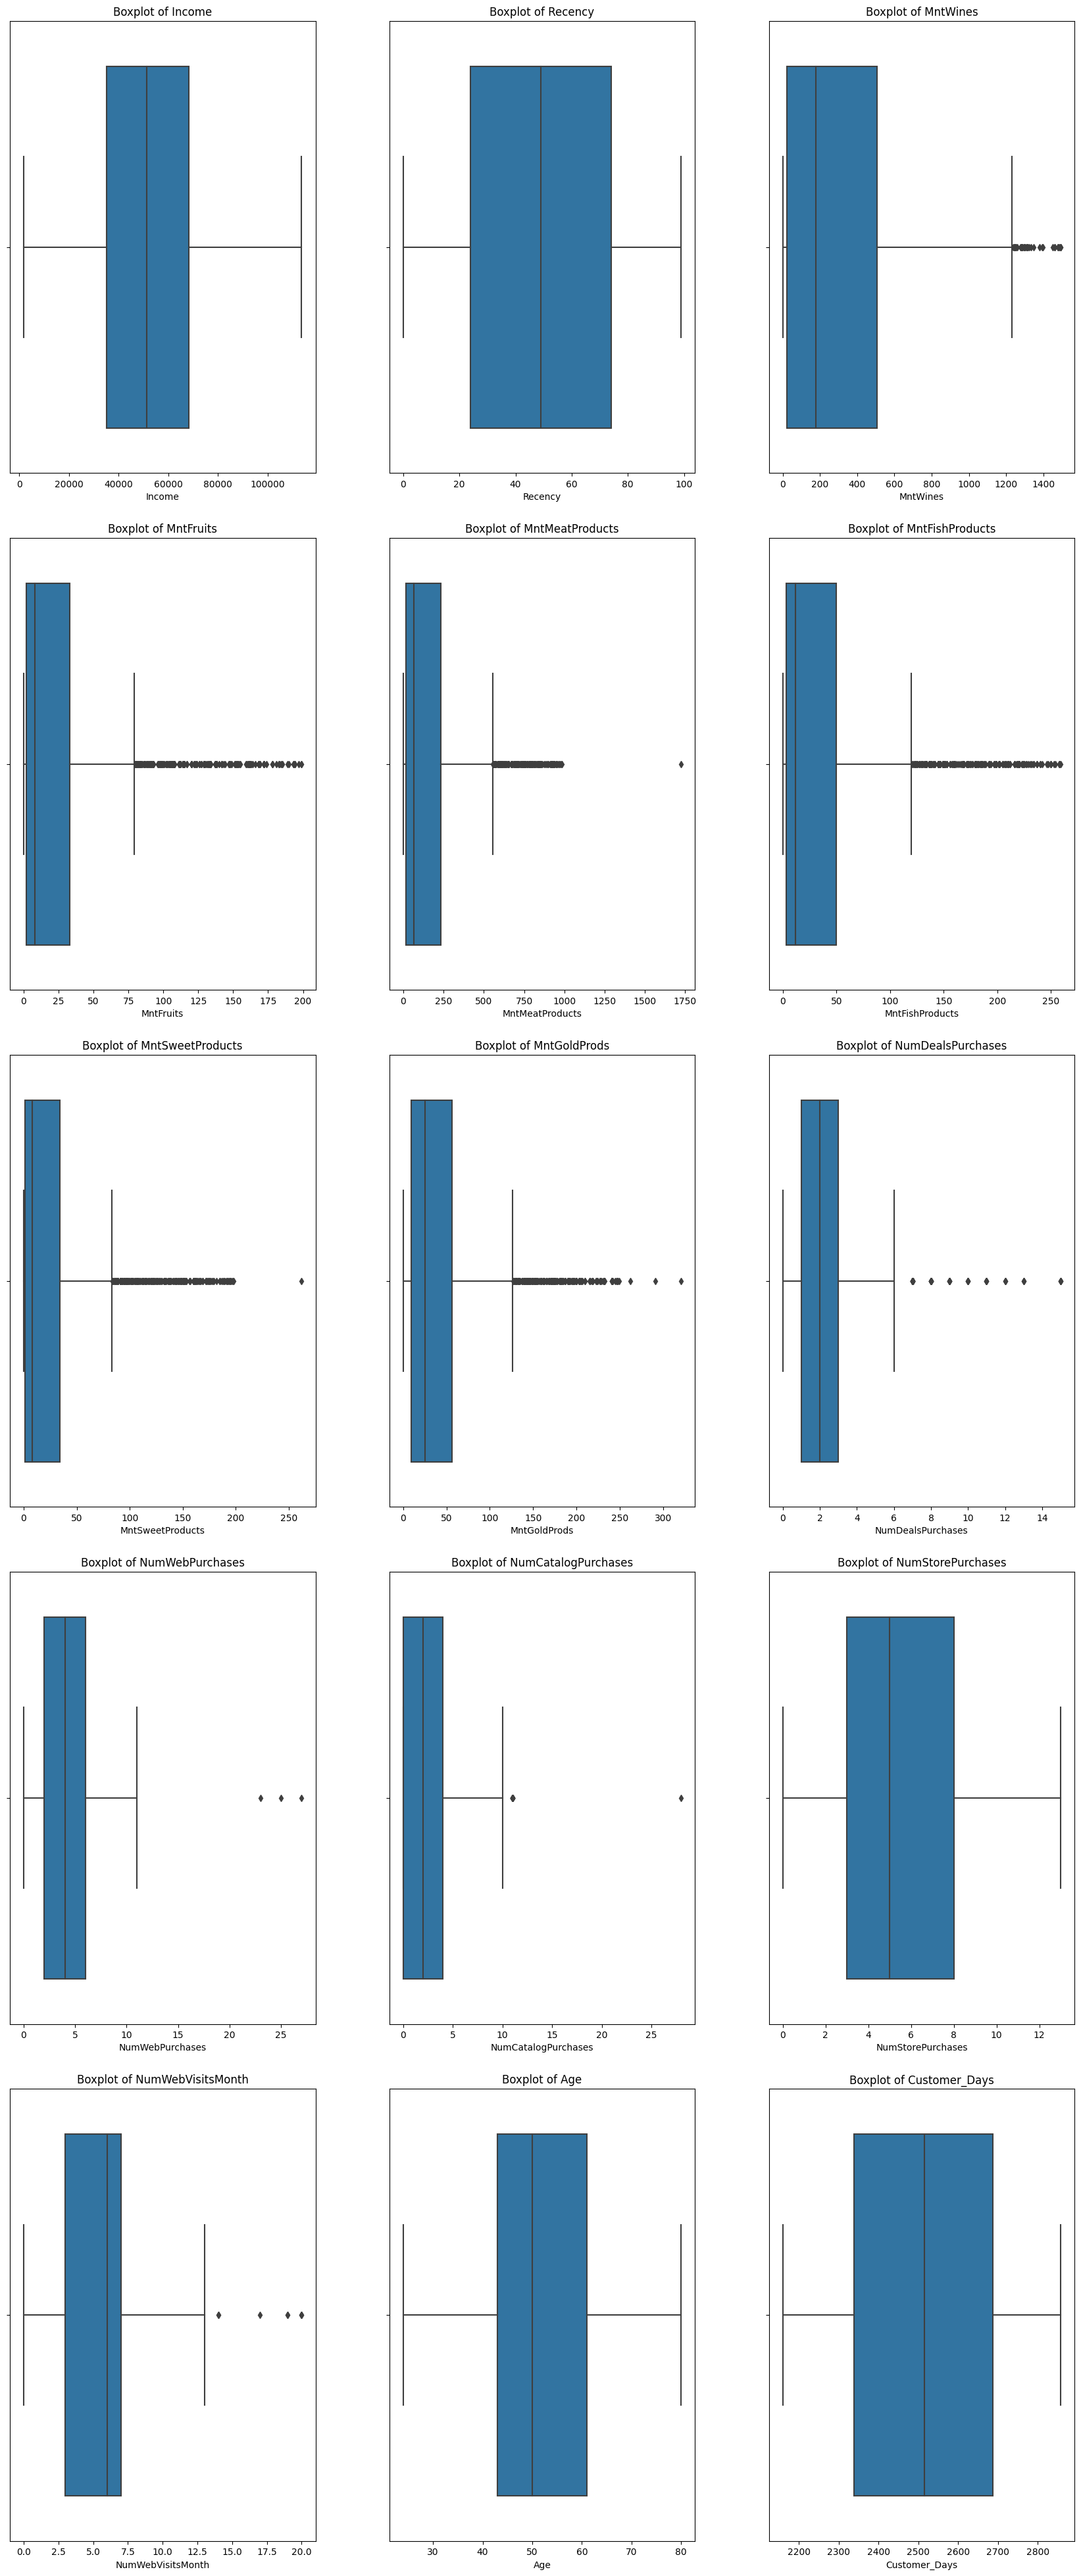

In [13]:
# List of numerical features to plot
numerical_features = [
    'Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
    'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
    'Age', 'Customer_Days'
]

# Create boxplots for numerical features
fig, axes = plt.subplots(len(numerical_features)//3 , 3, figsize=(18, 40))
fig.tight_layout(pad=5.0)

for i, feature in enumerate(numerical_features):
    sns.boxplot(data=marketing_data, x=feature, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'Boxplot of {feature}')

plt.show()

In [15]:
mean_year = marketing_data['Age'].mean()
std_year = marketing_data['Age'].std()

# Define the upper and lower bounds for outliers (3 standard deviations from the mean)
lower_bound_year = mean_year - 3 * std_year
upper_bound_year = mean_year + 3 * std_year

# Filter out outliers in Year_birth
data_cleaned = marketing_data[(marketing_data['Age'] >= lower_bound_year) & (marketing_data['Age'] <= upper_bound_year)]

# Feature Extraction

In [18]:
# 1. Calculate Minorhome
data_cleaned['Minorhome'] = data_cleaned['Kidhome'] + data_cleaned['Teenhome']

# 2. Sum up all the "Mnt"-related columns for Total_Mnt
mnt_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
data_cleaned['Total_Mnt'] = data_cleaned[mnt_columns].sum(axis=1)

# 3. Sum up all the "Num"-related columns for Total_num_purchase
num_columns = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
data_cleaned['Total_num_purchase'] = data_cleaned[num_columns].sum(axis=1)

# 4. Sum up all the "Accepted"-related columns and the "Response" column for Total_accept
accept_columns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
data_cleaned['Total_accept'] = data_cleaned[accept_columns].sum(axis=1)

# 5. Calculate AOV (Average Order Volume)
data_cleaned['AOV'] = data_cleaned['Total_Mnt'] / data_cleaned['Total_num_purchase']
data_cleaned['AOV'].replace([np.inf, -np.inf], 0, inplace=True)  

# Display the first few rows of the cleaned and transformed data with new features
data_cleaned.head()


,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall,Minorhome,Total_Mnt,Total_num_purchase,Total_accept,AOV
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,1529,1441,0,0,1617,25,1,64.680000
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,0,21,15,0,2,27,6,0,4.500000
2,71613.0,0,0,26,426,49,127,111,21,42,...,0,0,734,692,0,0,776,21,0,36.952381
3,26646.0,1,0,26,11,4,20,10,3,5,...,0,0,48,43,0,1,53,8,0,6.625000
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,1,407,392,0,1,422,19,0,22.210526


In [19]:
# Define thresholds for high spender and frequent buyer
high_spender_threshold = data_cleaned['Total_Mnt'].quantile(0.75)  # Top 25% spenders
frequent_buyer_threshold = data_cleaned['Total_num_purchase'].quantile(0.75)  # Top 25% buyers

# 1. High_Spender
data_cleaned['High_Spender'] = data_cleaned['Total_Mnt'] > high_spender_threshold

# 2. Frequent_Buyer
data_cleaned['Frequent_Buyer'] = data_cleaned['Total_num_purchase'] > frequent_buyer_threshold

# 3. Recent_Buyer (assuming a threshold for recency, e.g., less than 30 days)
recent_buyer_threshold = 30
data_cleaned['Recent_Buyer'] = data_cleaned['Recency'] < recent_buyer_threshold

# 4. Campaign_Responsiveness (ratio of total acceptances to number of campaigns targeted)
total_campaigns = len(accept_columns)
data_cleaned['Campaign_Responsiveness'] = data_cleaned['Total_accept'] / total_campaigns

# 5. Product_Preference (the product category the customer spends the most on)
data_cleaned['Product_Preference'] = data_cleaned[mnt_columns].idxmax(axis=1)


C:\Users\Admin\AppData\Local\Temp\ipykernel_1848\1378358298.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data_cleaned.corr()


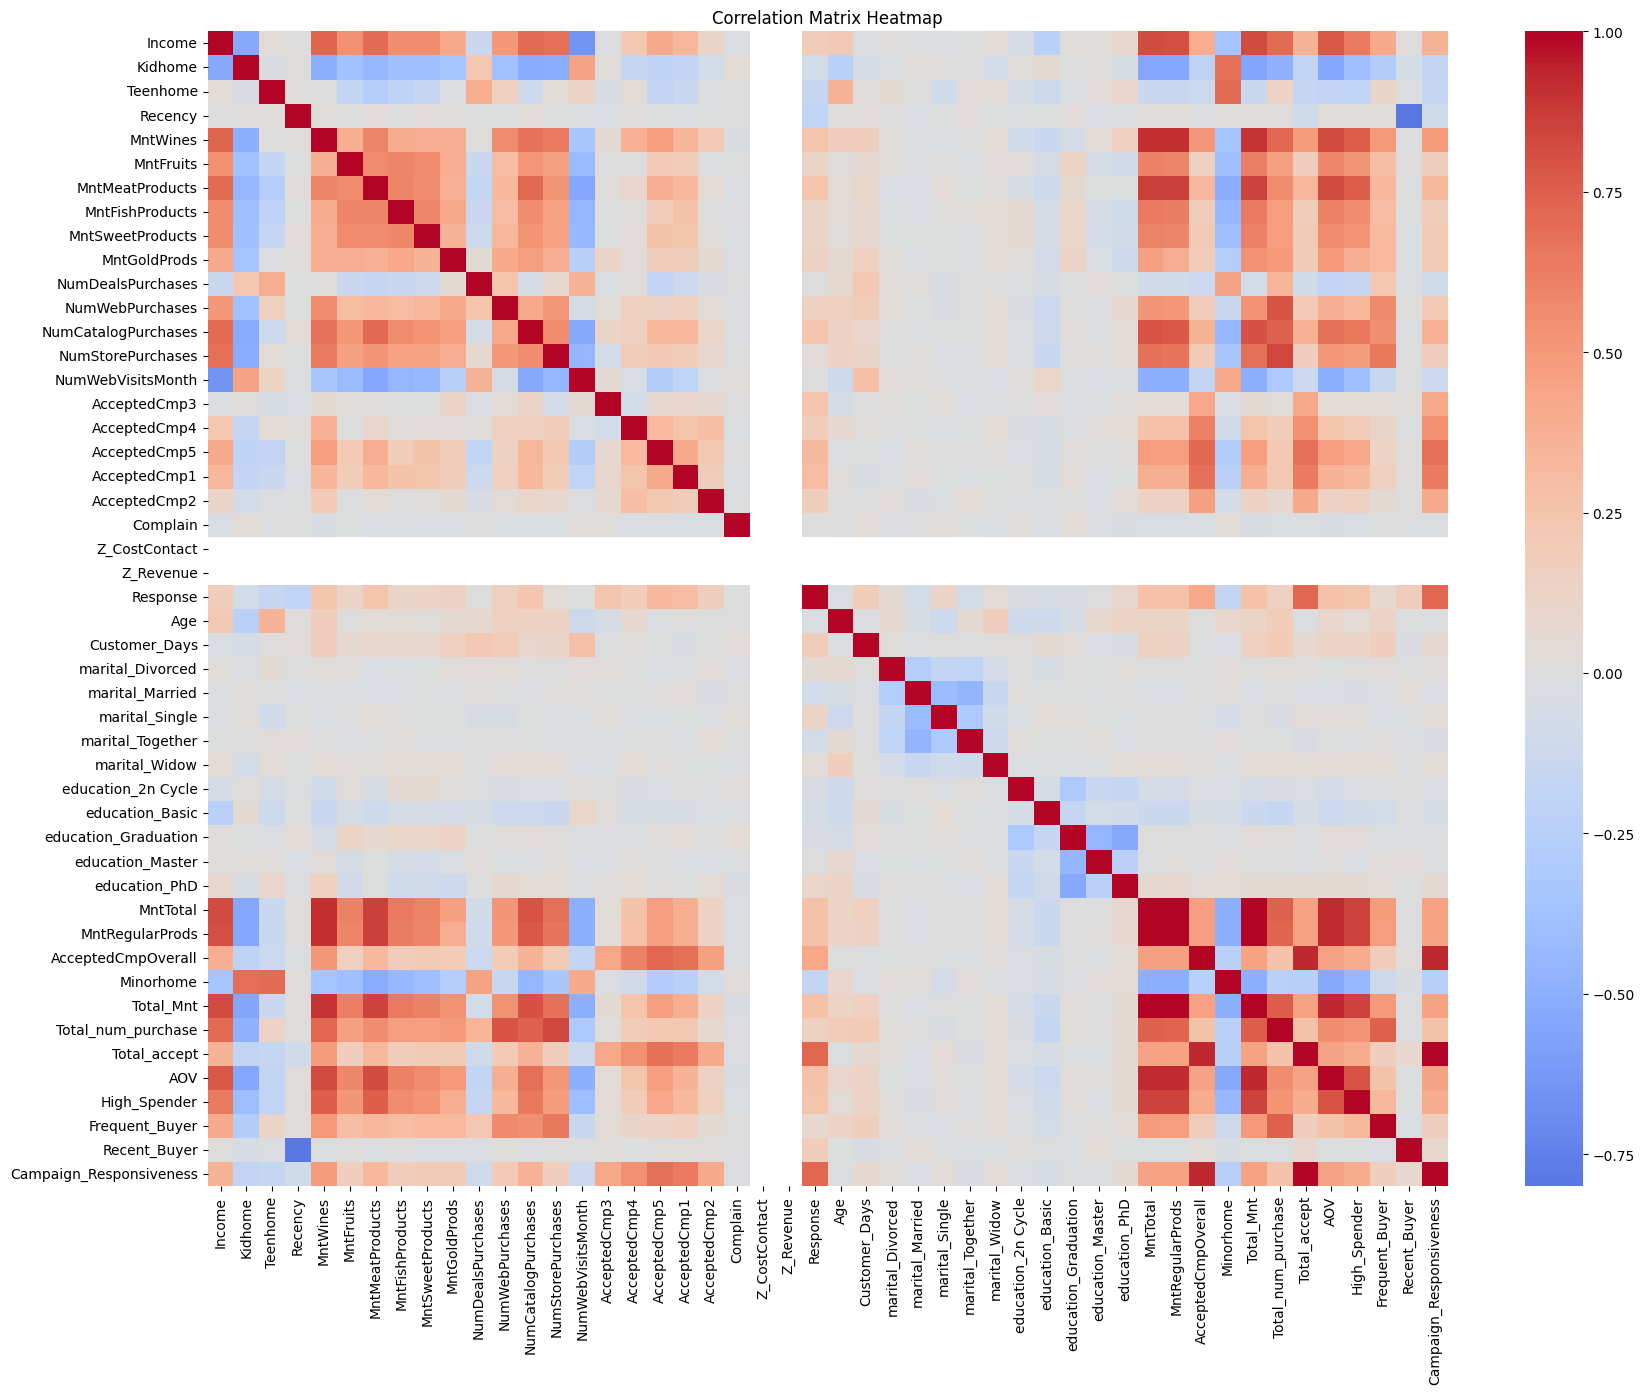

In [20]:
plt.figure(figsize=(20, 15))
correlation_matrix = data_cleaned.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

Observations:

Positive Correlations:

Total_Mnt and AOV: High correlation, indicating that customers who spend more overall also tend to have higher average order values.

Total_num_purchase and Total_accept: Positive correlation, suggesting that customers who make more purchases tend to accept more marketing offers.

MntWines, MntMeatProducts, and other Mnt columns: These show strong positive correlations among each other, indicating that customers who spend on one category are likely to spend on others as well.

Negative Correlations:

Recency and Total_Mnt: Negative correlation, meaning that more recent customers tend to spend more.

Recency and Total_num_purchase: Similarly, more recent customers tend to make more purchases.

Anomalies:

There don't appear to be any glaring anomalies in terms of unexpected correlations or patterns. The relationships observed are consistent with typical customer behavior in marketing datasets

## 1) What factors are significantly related to the number of store purchases?

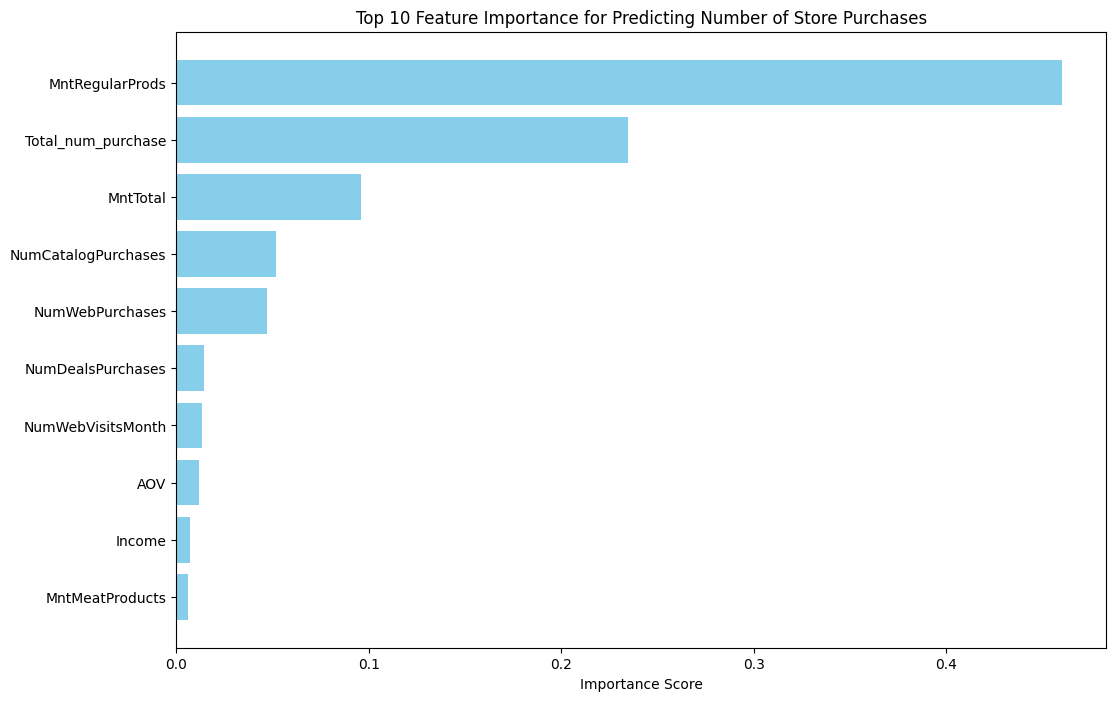

In [24]:

# Select numeric features and target variable
numeric_features = data_cleaned.select_dtypes(include=[np.number]).columns
X = data_cleaned[numeric_features].drop(columns=['NumStorePurchases'])
y = data_cleaned['NumStorePurchases']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a random forest regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Extract feature importance scores
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)


top_10_features = feature_importances.head(10)

plt.figure(figsize=(12, 8))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Top 10 Feature Importance for Predicting Number of Store Purchases')
plt.gca().invert_yaxis()
plt.show()


## PDPs show the relationship between the target response and a set of 'features of interest', marginalizing over the values of all other features (the complement features). This helps in understanding how the feature influences the prediction

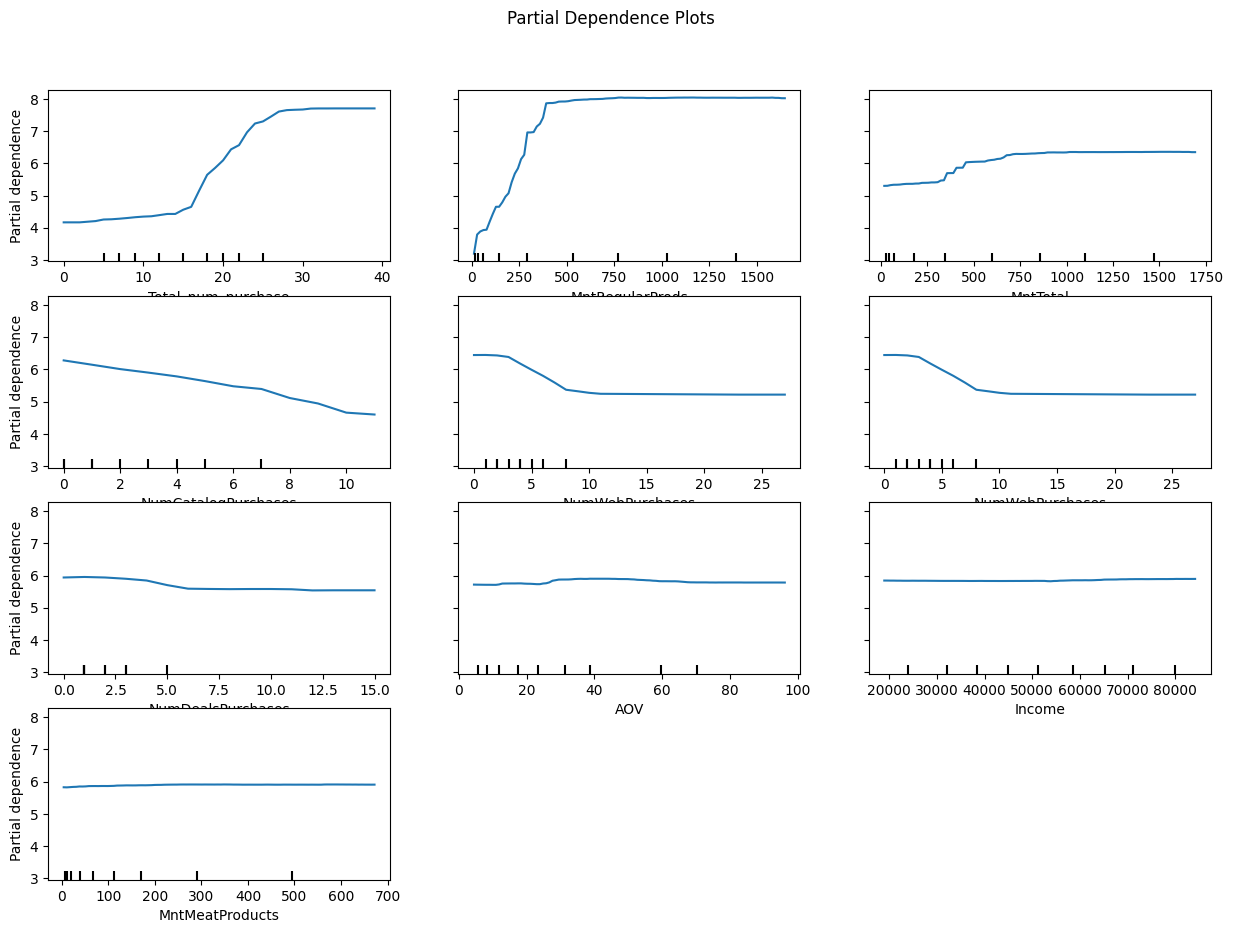

In [35]:
# Features to plot PDP for
features_to_plot = ['Total_num_purchase', 'MntRegularProds', 'MntTotal', 'NumCatalogPurchases', 'NumWebPurchases','NumWebPurchases',
                   'NumDealsPurchases','AOV','Income','MntMeatProducts']

# Plot PDP
fig, ax = plt.subplots(figsize=(15, 10))
PartialDependenceDisplay.from_estimator(rf_model, X_train, features_to_plot, ax=ax)
plt.suptitle('Partial Dependence Plots')
plt.subplots_adjust(top=0.9)  # Adjust title position
plt.show()


# The Partial Dependence Plots (PDPs) above provide insights into how each feature affects the number of store purchases:

Total_num_purchase: Shows a strong positive relationship with the number of store purchases.

MntRegularProds: Exhibits a positive impact.

MntTotal: Indicates a positive influence on store purchases.

NumCatalogPurchases: Shows a negative relationship.

NumWebPurchases: Also demonstrates a negative relationship.

# 2) lets check the accuracy of this claim: 
people who spent an above average amount on gold in the last 2 years would have more in store purchases

In [36]:
# Calculate the average amount spent on gold
average_gold_spent = data_cleaned['MntGoldProds'].mean()

# Create two groups: above-average and below-average gold spending
above_avg_gold = data_cleaned[data_cleaned['MntGoldProds'] > average_gold_spent]
below_avg_gold = data_cleaned[data_cleaned['MntGoldProds'] <= average_gold_spent]


In [38]:
# Perform the t-test
t_stat, p_value = ttest_ind(above_avg_gold['NumStorePurchases'], below_avg_gold['NumStorePurchases'])
t_stat, p_value

(20.847902683947776, 3.0437382439590913e-88)

the extremely low p-value (<0.05) indicates that there is a statistically significant difference in the number of in-store purchases between the two groups (those who spent above-average on gold and those who did not). The high t-statistic further supports the significant difference

# 3) Customer Profile Analysis

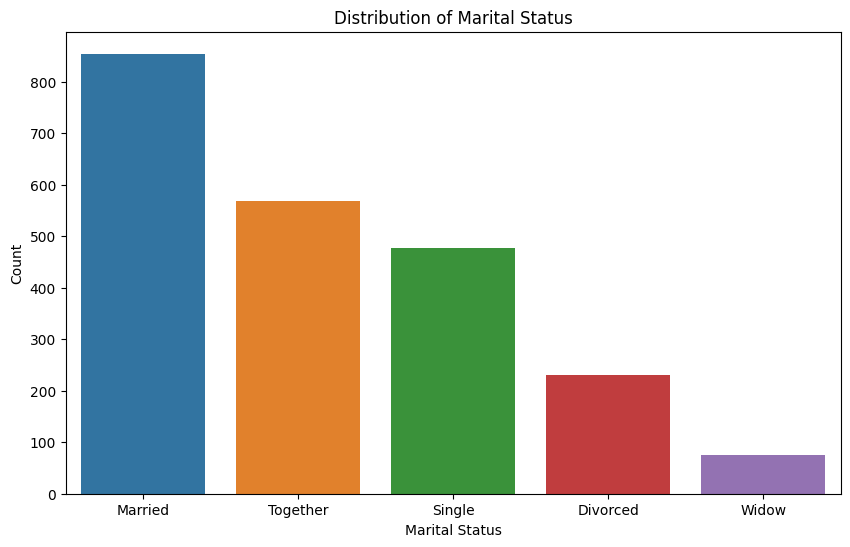

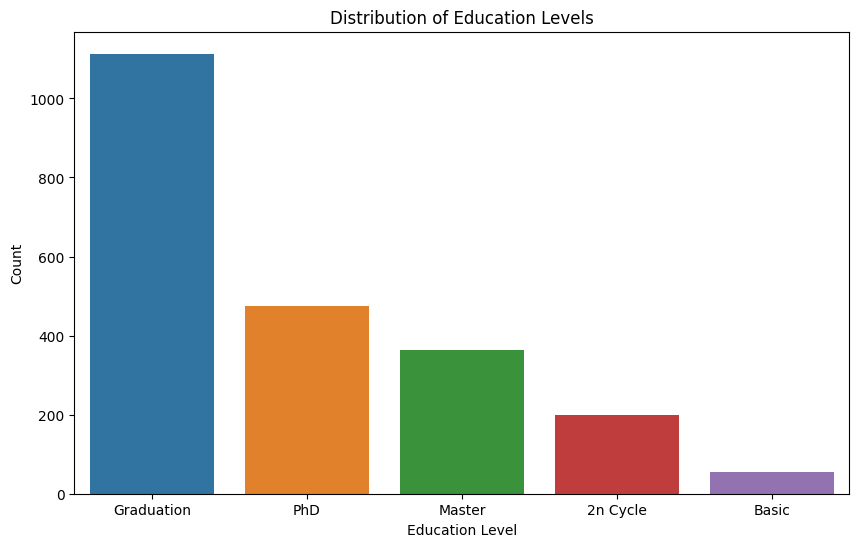

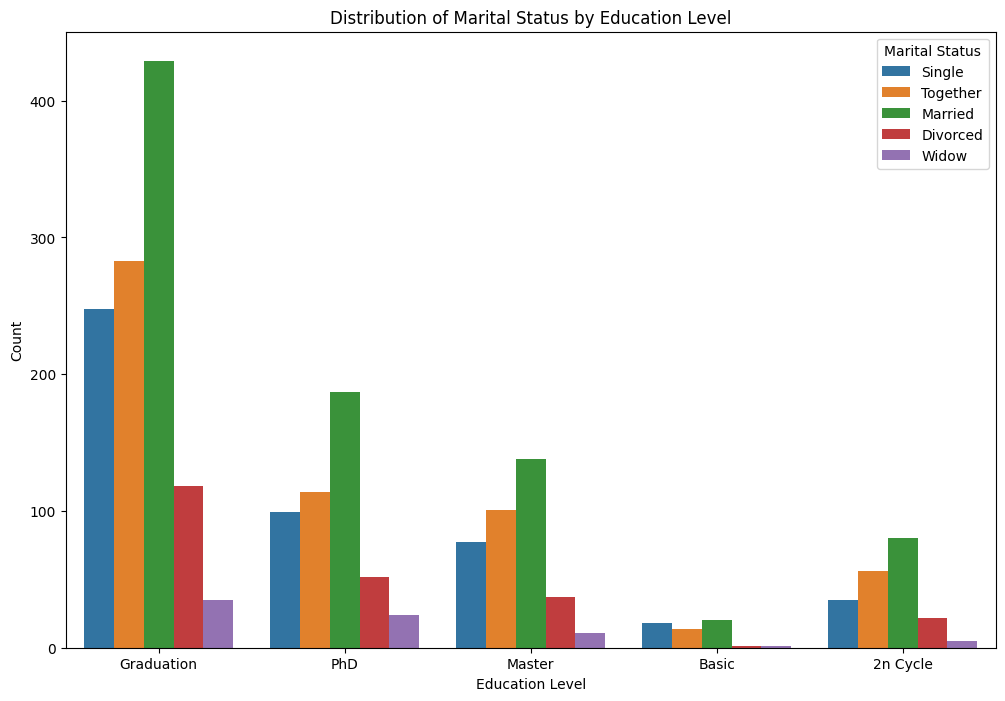

In [41]:
data_cleaned['Marital_Status'] = data_cleaned[['marital_Divorced', 'marital_Married', 'marital_Single', 'marital_Together', 'marital_Widow']].idxmax(axis=1).str.replace('marital_', '')
data_cleaned['Education'] = data_cleaned[['education_2n Cycle', 'education_Basic', 'education_Graduation', 'education_Master', 'education_PhD']].idxmax(axis=1).str.replace('education_', '')

# Plot the distribution of marital status
plt.figure(figsize=(10, 6))
sns.countplot(data=data_cleaned, x='Marital_Status', order=data_cleaned['Marital_Status'].value_counts().index)
plt.title('Distribution of Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.show()

# Plot the distribution of education levels
plt.figure(figsize=(10, 6))
sns.countplot(data=data_cleaned, x='Education', order=data_cleaned['Education'].value_counts().index)
plt.title('Distribution of Education Levels')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.show()

# Plot the combined distribution of marital status and education levels
plt.figure(figsize=(12, 8))
sns.countplot(data=data_cleaned, x='Education', hue='Marital_Status')
plt.title('Distribution of Marital Status by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.legend(title='Marital Status')
plt.show()


# 4) Customer Segmentation

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


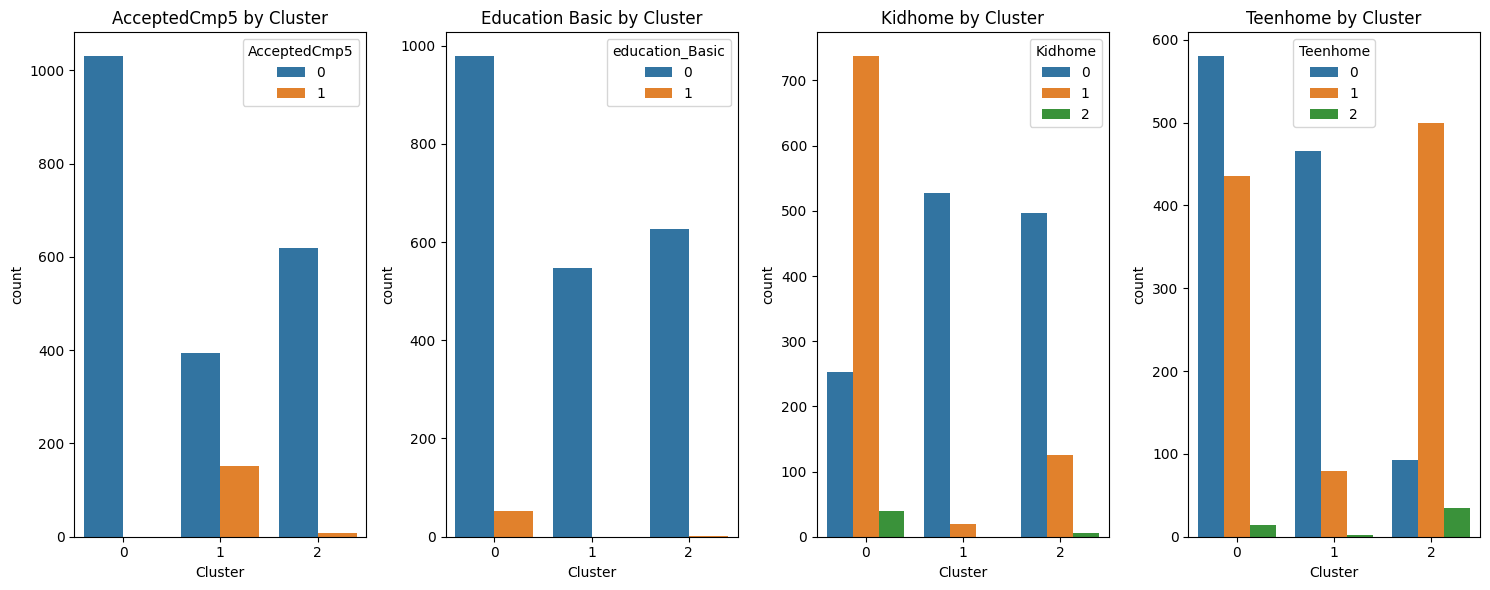

In [47]:

# Select relevant features for clustering
features_for_clustering = ['Income', 'Kidhome', 'Teenhome', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_cleaned[features_for_clustering])

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data_cleaned['Cluster'] = kmeans.fit_predict(X_scaled)

# Analyze the clusters
cluster_summary = data_cleaned.groupby('Cluster').agg({
    'Income': ['mean', 'count'],
    'Kidhome': 'mean',
    'Teenhome': 'mean',
    'MntWines': 'mean',
    'MntMeatProducts': 'mean',
    'AcceptedCmp5': 'mean'
}).reset_index()


# Plot the distribution of key features within each cluster
plt.figure(figsize=(15, 6))

plt.subplot(1, 4, 1)
sns.countplot(data=data_cleaned, x='Cluster', hue='AcceptedCmp5')
plt.title('AcceptedCmp5 by Cluster')

plt.subplot(1, 4, 2)
sns.countplot(data=data_cleaned, x='Cluster', hue='education_Basic')
plt.title('Education Basic by Cluster')

plt.subplot(1, 4, 3)
sns.countplot(data=data_cleaned, x='Cluster', hue='Kidhome')
plt.title('Kidhome by Cluster')

plt.subplot(1, 4, 4)
sns.countplot(data=data_cleaned, x='Cluster', hue='Teenhome')
plt.title('Teenhome by Cluster')

plt.tight_layout()
plt.show()


# 5) identifying the most effective campaign 

In [48]:
# Calculate the acceptance rate for each campaign
campaign_columns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
acceptance_rates = data_cleaned[campaign_columns].mean()

# Identify the most successful campaign
most_successful_campaign = acceptance_rates.idxmax()
most_successful_campaign, acceptance_rates[most_successful_campaign]


('AcceptedCmp4', 0.07437641723356009)

# 6) Average customer profile

In [50]:
# Profile the average customer
average_customer_profile = data_cleaned.describe().loc[['mean']]
average_customer_profile

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,MntTotal,MntRegularProds,AcceptedCmpOverall,Minorhome,Total_Mnt,Total_num_purchase,Total_accept,AOV,Campaign_Responsiveness,Cluster
mean,51622.094785,0.442177,0.506576,49.00907,306.164626,26.403175,165.312018,37.756463,27.128345,44.057143,...,562.764626,518.707483,0.29932,0.948753,606.821769,14.887982,0.45034,32.590924,0.075057,0.817687


# 7) Identify the Best-Performing Products

In [51]:
# Calculate total amount spent on each product category
product_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
total_spent_on_products = data_cleaned[product_columns].sum().sort_values(ascending=False)

total_spent_on_products


MntWines            675093
MntMeatProducts     364513
MntGoldProds         97146
MntFishProducts      83253
MntSweetProducts     59818
MntFruits            58219
dtype: int64

# 8) Investigate Differences in Customer Characteristics and Purchase Behaviors

In [54]:
# Customers who accepted the most successful campaign
accepted_customers = data_cleaned[data_cleaned[most_successful_campaign] == 1]

# Customers who did not accept the most successful campaign
non_accepted_customers = data_cleaned[data_cleaned[most_successful_campaign] == 0]

# Compare characteristics
accepted_vs_non_accepted = pd.concat([accepted_customers.describe().loc[['mean']], non_accepted_customers.describe().loc[['mean']]], keys=['Accepted', 'Not Accepted'])


accepted_vs_non_accepted


,,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,MntTotal,MntRegularProds,AcceptedCmpOverall,Minorhome,Total_Mnt,Total_num_purchase,Total_accept,AOV,Campaign_Responsiveness,Cluster
Accepted,mean,68663.231707,0.134146,0.579268,50.810976,750.231707,27.256098,239.664634,40.756098,31.286585,48.365854,...,1089.195122,1040.829268,1.768293,0.713415,1137.560976,20.067073,2.146341,57.424952,0.357724,1.451220
Not Accepted,mean,50252.792259,0.466928,0.500735,48.864282,270.482607,26.334640,159.337580,37.515434,26.794219,43.710926,...,520.464478,476.753552,0.181284,0.967663,564.175404,14.471828,0.314062,30.595441,0.052344,0.766781


# Summary of finding: 

Campaign 4 is the most successful.

Average Customer: Middle-income, typically with one child or teenager, and moderate spending habits.

Best-Performing Products: Wines and meat products are the top-selling categories.

Customer Differences: Customers who accepted Campaign 4 tend to have higher income, spend significantly more, and are more responsive to campaigns.

# 9) LifeTime Value Analysis

In [55]:
# Prepare data for LTV prediction
features = ['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntMeatProducts', 'Total_Mnt', 'Total_num_purchase']
target = 'Total_Mnt'

X = data_cleaned[features]
y = data_cleaned[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict LTV for the test set
y_pred = lr_model.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, mse, r2


(7.193793060405699e-12, 7.096911040560074e-23, 1.0)

# 10) Churn Analysis

In [62]:
# Adjust the churn definition (e.g., customers who have not made a purchase in the last 3 months)
data_cleaned['Churn'] = data_cleaned['Recency'] > 90

churn_distribution_updated = data_cleaned['Churn'].value_counts()
churn_distribution_updated


False    2012
True      193
Name: Churn, dtype: int64

In [63]:
# Prepare data for churn prediction
features = ['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntMeatProducts', 'Total_Mnt', 'Total_num_purchase']
target = 'Churn'

X = data_cleaned[features]
y = data_cleaned[target].astype(int)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a logistic regression model
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Predict churn for the test set
y_pred = lr_model.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

accuracy, precision, recall, f1


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.9033232628398792,
 0.4594594594594595,
 0.2786885245901639,
 0.3469387755102041)

# 11) Market Basket Analysis

In [70]:
# Select product columns
product_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

# Convert product columns to binary format (0 or 1)
basket = data_cleaned[product_columns].applymap(lambda x: 1 if x > 0 else 0)

# Apply the Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Display top 6 association rules based on lift
top_rules = rules.sort_values(by='lift', ascending=False).head(10)
top_rules




C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
540,"(MntSweetProducts, MntFruits)","(MntWines, MntFishProducts, MntMeatProducts, M...",0.724717,0.804535,0.646712,0.892365,1.109169,0.063652,1.816005,0.357537
423,"(MntSweetProducts, MntFruits)","(MntWines, MntFishProducts, MntGoldProds)",0.724717,0.804535,0.646712,0.892365,1.109169,0.063652,1.816005,0.357537
515,"(MntMeatProducts, MntSweetProducts, MntFruits)","(MntWines, MntFishProducts, MntGoldProds)",0.724717,0.804535,0.646712,0.892365,1.109169,0.063652,1.816005,0.357537
493,"(MntWines, MntFishProducts, MntMeatProducts, M...","(MntSweetProducts, MntFruits)",0.804535,0.724717,0.646712,0.803833,1.109169,0.063652,1.403313,0.503539
406,"(MntWines, MntFishProducts, MntGoldProds)","(MntSweetProducts, MntFruits)",0.804535,0.724717,0.646712,0.803833,1.109169,0.063652,1.403313,0.503539
518,"(MntWines, MntFishProducts, MntGoldProds)","(MntMeatProducts, MntSweetProducts, MntFruits)",0.804535,0.724717,0.646712,0.803833,1.109169,0.063652,1.403313,0.503539
492,"(MntWines, MntMeatProducts, MntSweetProducts, ...","(MntFishProducts, MntFruits)",0.792744,0.736054,0.646712,0.815789,1.108328,0.063209,1.432847,0.471589
541,"(MntFishProducts, MntFruits)","(MntWines, MntMeatProducts, MntSweetProducts, ...",0.736054,0.792744,0.646712,0.878620,1.108328,0.063209,1.707497,0.370303
424,"(MntFishProducts, MntFruits)","(MntWines, MntSweetProducts, MntGoldProds)",0.736054,0.792744,0.646712,0.878620,1.108328,0.063209,1.707497,0.370303
405,"(MntWines, MntSweetProducts, MntGoldProds)","(MntFishProducts, MntFruits)",0.792744,0.736054,0.646712,0.815789,1.108328,0.063209,1.432847,0.471589


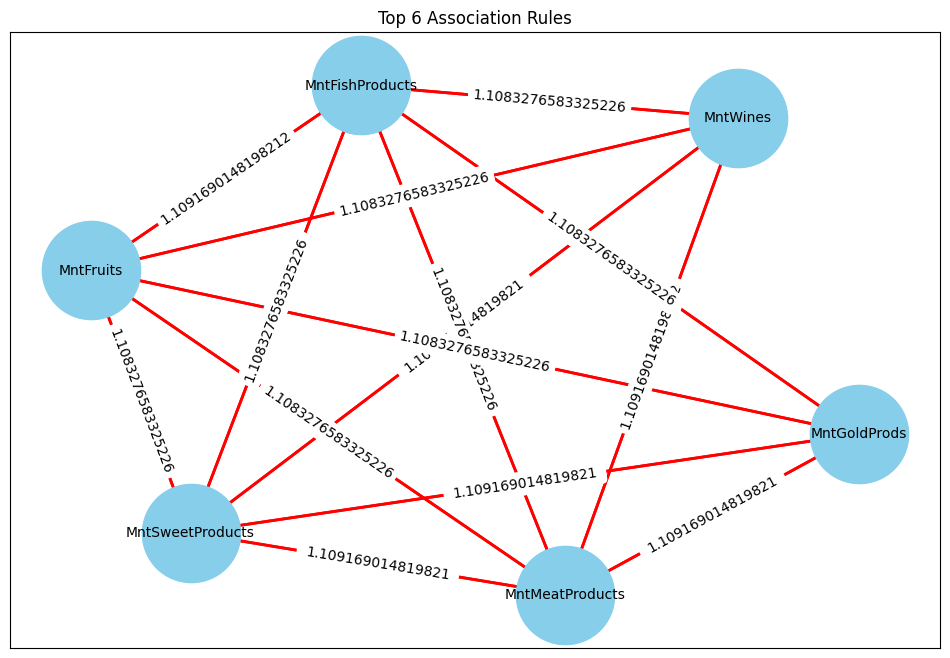

In [72]:
# Create a directed graph from the association rules
G = nx.DiGraph()

# Add nodes and edges for the top 6 rules
for _, row in top_rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, weight=row['lift'])

# Define the position of nodes
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Draw the nodes
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=5000, node_color='skyblue')

# Draw the edges
edges = nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, edge_color='r', width=2)

# Draw the labels
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

# Add edge labels
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title('Top 6 Association Rules')
plt.show()


# 12) Customer journey analysis

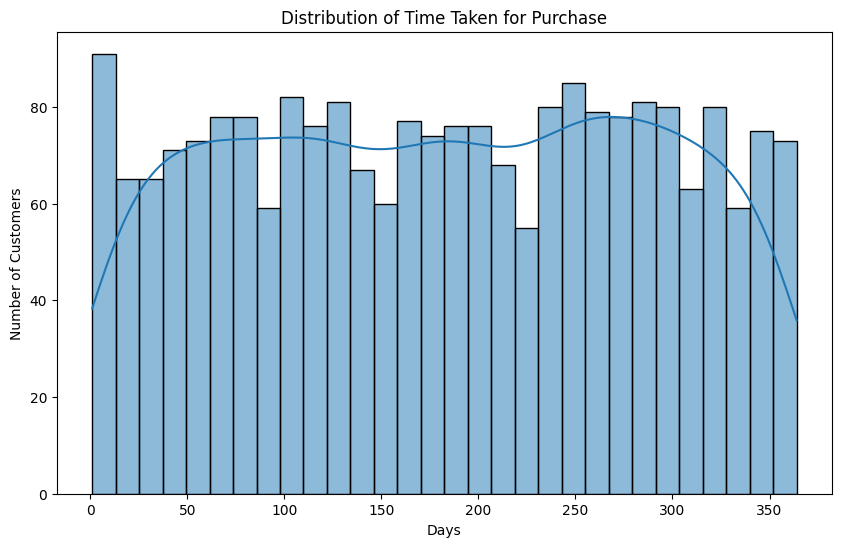

In [68]:
# Create a synthetic CustomerID column
data_cleaned['CustomerID'] = range(1, len(data_cleaned) + 1)

# Create synthetic data for demonstration purposes
np.random.seed(0)
data_cleaned['First_Contact'] = np.random.choice(pd.date_range(start='2020-01-01', end='2020-12-31'), size=len(data_cleaned))
data_cleaned['Purchase_Date'] = data_cleaned['First_Contact'] + pd.to_timedelta(np.random.randint(1, 365, size=len(data_cleaned)), unit='d')

# Aggregate data by customer journeys
journeys = data_cleaned.groupby('CustomerID').agg({
    'First_Contact': 'min',
    'Purchase_Date': 'min'
}).reset_index()

# Calculate the time taken for purchase
journeys['Time_to_Purchase'] = (journeys['Purchase_Date'] - journeys['First_Contact']).dt.days

# Visualize the time taken for purchase
plt.figure(figsize=(10, 6))
sns.histplot(journeys['Time_to_Purchase'], bins=30, kde=True)
plt.title('Distribution of Time Taken for Purchase')
plt.xlabel('Days')
plt.ylabel('Number of Customers')
plt.show()
